In [12]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm

class NonMarkovianSequenceModel:
    """
    Non-Markovian Gaussian Sequence Model
    """
    def __init__(self, phi, beta, q, r):
        """
        Parameters
        ----------
        phi: float
            Multiplicative effect in latent-space
        beta: float
            Decay relate in observed-space
        q: float
            Variance in latent-space
        r: float
            Variance in observed-space
        """
        self.phi = phi
        self.beta = beta
        self.q = q
        self.r = r
    
    @staticmethod
    def _obtain_weights(log_weights):
        weights = jnp.exp(log_weights - jax.nn.logsumexp(log_weights))
        return weights

    def sample_latent_step(self, key, x_prev):
        x_next = jax.random.normal(key) * jnp.sqrt(self.q) + self.phi * x_prev
        return x_next
    
    def sample_observed_step(self, key, mu, x_curr):
        mu_next = self.beta * mu + x_curr
        y_curr = jax.random.normal(key) * jnp.sqrt(self.r) + mu_next
        return y_curr, mu_next
    
    def sample_step(self, key, x_prev, mu_prev):
        key_latent, key_obs = jax.random.split(key)
        x_curr = self.sample_latent_step(key_latent, x_prev)
        y_curr, mu = self.sample_observed_step(key_obs, mu_prev, x_curr)
        
        carry_vals = {"x": x_curr, "y": y_curr}
        return (x_curr, mu), carry_vals
    
    def sample_single(self, key, nsteps):
        """
        Sample a single path from the non-Markovian Gaussian state-space model.
        
        Parameters
        ----------
        key: jax.random.PRNGKey
            Initial seed
        
        """
        key_init, key_simul = jax.random.split(key)
        x_init = jax.random.normal(key_init) * jnp.sqrt(self.q)
        mu_init = 0
        
        keys = jax.random.split(key_simul, nsteps)    
        carry_init = (x_init, mu_init)
        _, hist = jax.lax.scan(lambda carry, key: self.sample_step(key, *carry), carry_init, keys)
        return hist
    
    def sample(self, key, nsteps, nsims=1):
        """
        Sample from a non-Markovian Gaussian state-space model.
        
        Parameters
        ----------
        key: jax.random.PRNGKey
            Initial key to perform the simulation.
        nsteps: int
            Total number of steps to sample.
        nsims: int
            Number of paths to sample.
        """
        key_simulations = jax.random.split(key, nsims)
        sample_vmap = jax.vmap(self.sample_single, (0, None))
        
        simulations = sample_vmap(key_simulations, nsteps)
        
        # convert to one-dimensional array if only one simulation is
        # required
        if nsims == 1:
            for key, values in simulations.items():
                simulations[key] = values.ravel()
        
        return simulations
    
    def _sis_step(self, key, log_weights_prev, mu_prev, xparticles_prev, yobs):
        """
        Compute one step of the sequential-importance-sampling algorithm
        at time t.
        
        Parameters
        ----------
        key: jax.random.PRNGKey
            key to sample particle.
        mu_prev: array(n_particles)
            Term carrying past cumulate values.
        xsamp_prev: array(n_particles)
            Samples / particles from the latent space at t-1
        yobs: float
            Observation at time t.
        """
        
        key_particles = jax.random.split(key, len(xparticles_prev))
        
        # 1. Sample from proposal
        xparticles = jax.vmap(self.sample_latent_step)(key_particles, xparticles_prev)
        # 2. Evaluate unnormalised weights
        # 2.1 Compute new mean
        mu = self.beta * mu_prev + xparticles
        # 2.2 Compute log-unnormalised weights
        
        log_weights = log_weights_prev + norm.logpdf(yobs, loc=mu, scale=jnp.sqrt(self.q))
        dict_carry = {
            "log_weights": log_weights,
            "particles": xparticles,
        }
        
        return (log_weights, mu, xparticles), dict_carry
    
    def sequential_importance_sample(self, key, observations, n_particles=10):
        """
        Apply sequential importance sampling (SIS) to a series of observations. Sampling
        considers the transition distribution as the proposal.
        
        Parameters
        ----------
        key: jax.random.PRNGKey
            Initial key.
        observations: array(n_observations)
            one-array of observed values.
        n_particles: int (default: 10)
            Total number of particles to consider in the SIS filter.
        """
        T = len(observations)
        key, key_init_particles = jax.random.split(key)
        keys = jax.random.split(key, T)
        
        init_log_weights = jnp.zeros(n_particles)
        init_mu = jnp.zeros(n_particles) # equiv. ∀n.wn=1.0
        init_xparticles = jax.random.normal(key_init_particles, shape=(n_particles,)) * jnp.sqrt(self.q)
        
        carry_init = (init_log_weights, init_mu, init_xparticles)
        xs_tuple = (keys, observations)
        _, dict_hist = jax.lax.scan(lambda carry, xs: self._sis_step(xs[0], *carry, xs[1]), carry_init, xs_tuple)
        dict_hist["weights"] = jnp.exp(dict_hist["log_weights"] - jax.nn.logsumexp(dict_hist["log_weights"], axis=1, keepdims=True))

        return dict_hist
    
    def _smc_step(self, key, log_weights_prev, mu_prev, xparticles_prev, yobs):
        n_particles = len(xparticles_prev)
        key, key_particles = jax.random.split(key)
        key_particles = jax.random.split(key_particles, n_particles)
        
        # 1. Resample particles
        weights = self._obtain_weights(log_weights_prev)
        ix_sampled = jax.random.choice(key, n_particles, p=weights, shape=(n_particles,))
        print(ix_sampled)
        xparticles_prev_sampled = xparticles_prev[ix_sampled]
        mu_prev_sampled = mu_prev[ix_sampled]
        # 2. Propagate particles
        xparticles = jax.vmap(self.sample_latent_step)(key_particles, xparticles_prev_sampled)
        # 3. Concatenate
        mu = self.beta * mu_prev_sampled + xparticles

        # ToDo: return dictionary of log_weights and sampled indices
        log_weights = norm.logpdf(yobs, loc=mu, scale=jnp.sqrt(self.q))
        dict_carry = {
            "log_weights": log_weights,
            "indices": ix_sampled,
            "particles": xparticles,
        }
        return (log_weights, mu, xparticles_prev_sampled), dict_carry

    def sequential_monte_carlo(self, key, observations, n_particles=10):
        """
        Apply sequential Monte Carlo (SCM), a.k.a sequential importance resampling (SIR),
        a.k.a sequential importance sampling and resampling(SISR).
        """
        T = len(observations)
        key, key_particle_init = jax.random.split(key)
        keys = jax.random.split(key, T)
        
        init_xparticles = jax.random.normal(key_particle_init, shape=(n_particles,)) * jnp.sqrt(self.q)
        init_log_weights = jnp.zeros(n_particles) # equiv. ∀n.wn=1.0
        init_mu = jnp.zeros(n_particles)
        
        carry_init = (init_log_weights, init_mu, init_xparticles)
        xs_tuple = (keys, observations)
        _, dict_hist = jax.lax.scan(lambda carry, xs: self._smc_step(xs[0], *carry, xs[1]), carry_init, xs_tuple)
        # transform log-unnormalised weights to weights
        dict_hist["weights"] = jnp.exp(dict_hist["log_weights"] - jax.nn.logsumexp(dict_hist["log_weights"], axis=1, keepdims=True))
        
        return dict_hist
    

In [7]:
import matplotlib.pyplot as plt

def find_path(ix_path, final_state):
    curr_state = final_state
    path = [curr_state]
    for i in range(1, 7):
        curr_state, _ = ix_path[:, -i, curr_state]
        path.append(curr_state)
    path = path[::-1]
    return path


def plot_sis_weights(hist, n_steps, spacing=1.5, max_size=0.3):
    """
    Plot the evolution of weights in the sequential importance sampling (SIS) algorithm.

    Parameters
    ----------
    weights: array(n_particles, n_steps)
        Weights at each time step.
    n_steps: int
        Number of steps to plot.
    spacing: float
        Spacing between particles.
    max_size: float
        Maximum size of the particles.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect(1)
    weights_subset = hist["weights"][:n_steps]
    for col, weights_row in enumerate(weights_subset):
        norm_cst = weights_row.sum()
        radii = weights_row / norm_cst * max_size
        for row, rad in enumerate(radii):
            if col != n_steps - 1:
                plt.arrow(spacing * (col + 0.25), row, 0.6, 0, width=0.05,
                          edgecolor="white", facecolor="tab:gray")
            circle = plt.Circle((spacing * col, row), rad, color="tab:red")
            ax.add_artist(circle)

    plt.xlim(-1, n_steps * spacing)
    plt.xlabel("Iteration (t)")
    plt.ylabel("Particle index (i)")

    xticks_pos = jnp.arange(0, n_steps * spacing - 1, 2)
    xticks_lab = jnp.arange(1, n_steps + 1)
    plt.xticks(xticks_pos, xticks_lab)

    return fig, ax

def plot_smc_weights_unique(hist, n_steps, spacing=1.5, max_size=0.3):
    """
    We plot the evolution of particles that have been consistently resampled and form our final
    approximation of the target distribution using sequential Monte Carlo (SMC).

    Parameters
    ----------
    weights: array(n_particles, n_steps)
        Weights at each time step.
    n_steps: int
        Number of steps to plot.
    spacing: float
        Spacing between particles.
    max_size: float
        Maximum size of the particles.
    

    Returns
    -------
    fig: matplotlib.figure.Figure
        Figure containing the plot.
    """
    weights_subset = hist["weights"][:n_steps]
    # sampled indices represent the "position" of weights at the next time step
    ix_subset = hist["indices"][:n_steps][1:]
    ix_path = ix_subset[:n_steps - 2]
    ix_map = jnp.repeat(jnp.arange(5)[None, :], 6, axis=0)
    ix_path = jnp.stack([ix_path, ix_map], axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect(1)

    for final_state in range(5):
        path = find_path(ix_path, final_state)
        path_beg, path_end = path[:-1], path[1:]
        for it, (beg, end) in enumerate(zip(path_beg, path_end)):
            diff = end - beg
            plt.arrow(spacing * (it + 0.15), beg, 1.3, diff, width=0.05,
                    edgecolor="white", facecolor="tab:gray", alpha=1.0, length_includes_head=True)

    for it, weights_row in enumerate(weights_subset[:-1]):
        norm_cst = weights_row.sum()
        radii = weights_row / norm_cst * max_size
        
        for particle_ix, rad in enumerate(radii):
            circle = plt.Circle((spacing * it, particle_ix), rad, color="tab:blue")
            ax.add_artist(circle)
            
    plt.xlim(-1, n_steps * spacing - 2)
    plt.xlabel("Iteration (t)")
    plt.ylabel("Particle index (i)")

    xticks_pos = jnp.arange(0, n_steps * spacing - 2, 2)
    xticks_lab = jnp.arange(1, n_steps)

    plt.xticks(xticks_pos, xticks_lab)

    return fig, ax

def plot_smc_weights(hist, n_steps, spacing=1.5, max_size=0.3):
    """
    Plot the evolution of weights in the sequential Monte Carlo (SMC) algorithm.

    Parameters
    ----------
    weights: array(n_particles, n_steps)
        Weights at each time step.
    n_steps: int
        Number of steps to plot.
    spacing: float
        Spacing between particles.
    max_size: float
        Maximum size of the particles.
    
    Returns
    -------
    fig: matplotlib.figure.Figure
        Figure containing the plot.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect(1)

    weights_subset = hist["weights"][:n_steps]
    # sampled indices represent the "position" of weights at the next time step
    ix_subset = hist["indices"][:n_steps][1:]

    for it, (weights_row, p_target) in enumerate(zip(weights_subset, ix_subset)):
        norm_cst = weights_row.sum()
        radii = weights_row / norm_cst * max_size
        print(radii, p_target)
        for particle_ix, (rad, target_ix) in enumerate(zip(radii, p_target)):
            # print(rad, target_ix)
            if it != n_steps - 2:
                diff = particle_ix - target_ix
                plt.arrow(spacing * (it + 0.15), target_ix, 1.3, diff, width=0.05,
                        edgecolor="white", facecolor="tab:gray", length_includes_head=True)
            circle = plt.Circle((spacing * it, particle_ix), rad, color="tab:blue")
            ax.add_artist(circle)

    plt.xlim(-1, n_steps * spacing - 2)
    plt.xlabel("Iteration (t)")
    plt.ylabel("Particle index (i)")

    xticks_pos = jnp.arange(0, n_steps * spacing - 2, 2)
    xticks_lab = jnp.arange(1, n_steps)
    plt.xticks(xticks_pos, xticks_lab)

    # ylims = ax.axes.get_ylim() # to-do: grab this value for SCM-particle descendents' plot

    return fig, ax

In [13]:
params = {
        "phi": 0.9,
        "q": 1.0,
        "beta": 0.5,
        "r": 1.0,
    }

key = jax.random.PRNGKey(314)
key_sample, key_sis, key_scm = jax.random.split(key, 3)
seq_model = NonMarkovianSequenceModel(**params)
hist_target = seq_model.sample(key_sample, 10)
observations = hist_target["y"]

# res_sis = seq_model.sequential_importance_sample(key_sis, observations, n_particles=5)
res_smc = seq_model.sequential_monte_carlo(key_scm, observations, n_particles=5)
# print(res_smc)
# Plot SMC particle evolution
# n_steps = 6 + 2
# spacing = 2

# dict_figures = {}

# fig, ax = plot_sis_weights(res_sis, n_steps=7, spacing=spacing)
# plt.tight_layout()

Traced<ShapedArray(int32[5])>with<DynamicJaxprTrace(level=1/0)>


In [9]:
print(res_smc)

{'indices': Array([[1, 0, 2, 3, 1],
       [3, 0, 1, 0, 2],
       [0, 4, 1, 4, 0],
       [2, 0, 2, 2, 1],
       [4, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [4, 4, 2, 4, 4],
       [0, 0, 0, 0, 0],
       [4, 4, 4, 4, 4],
       [1, 1, 1, 1, 1],
       [3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [2, 4, 4, 4, 4],
       [3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3],
       [2, 3, 3, 4, 4],
       [1, 2, 4, 4, 3],
       [3, 3, 4, 1, 3],
       [4, 4, 1, 4, 4],
       [1, 1, 1, 1, 1],
       [3, 0, 2, 0, 1],
       [0, 3, 1, 1, 3],
       [4, 4, 4, 4, 4],
       [2, 1, 2, 0, 2],
       [0, 0, 3, 0, 0],
       [3, 2, 3, 1, 2],
       [2, 2, 2, 2, 3],
       [2, 0, 4, 4, 1],
       [4, 3, 3, 0, 4],
       [1, 1, 1, 1, 1],
       [4, 4, 4, 4, 4],
       [2, 2, 2, 2, 2],
       [4, 0, 4, 0, 4],
       [1, 1, 1, 0, 0],
       [2, 1, 2, 0, 4],
       [0, 1, 1, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4],
    

[0.0636521  0.07141752 0.07944639 0.02784852 0.05763548] [3 0 1 0 2]
[0.06496386 0.04908603 0.1110201  0.01199263 0.06293741] [0 4 1 4 0]
[0.00843192 0.08711156 0.05106996 0.08712619 0.06626037] [2 0 2 2 1]
[0.00083059 0.00855414 0.23246594 0.02341465 0.0347347 ] [4 2 2 2 2]
[0.0012136  0.00833982 0.16743255 0.11774657 0.00526748] [2 2 2 2 2]
[5.1695155e-03 2.9268873e-01 2.1103207e-05 2.1544370e-06 2.1185300e-03] [1 1 1 1 1]
[8.2548141e-08 2.9932779e-01 4.2814793e-04 2.6377879e-08 2.4397578e-04] [1 1 1 1 1]


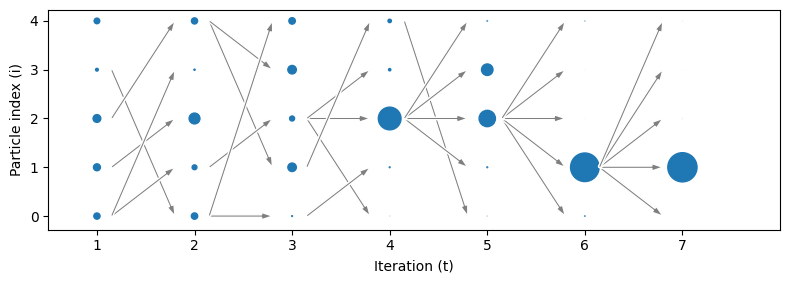

In [8]:
fig, ax = plot_smc_weights(res_smc, n_steps=n_steps, spacing=spacing)
ylims = ax.axes.get_ylim()
plt.tight_layout()

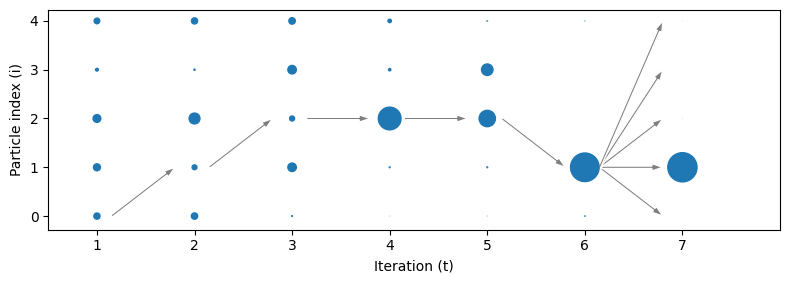

In [21]:
fig, ax = plot_smc_weights_unique(res_smc, n_steps=n_steps, spacing=spacing)
ax.set_ylim(*ylims)
plt.tight_layout()

In [35]:
import jax 
import jax.numpy as jnp
key = jax.random.PRNGKey(314)
# sample_keys = jax.random.split(key,5)
# samples = jax.vmap(lambda key : jax.random.normal(key))(sample_keys)
# print(samples)
# jax.random.choice(key, 5, p=jnp.array([1,1,0,0,1]), shape=(5,100,))
jnp.repeat(jnp.arange(5)[None, :], 6, axis=0)

Array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]], dtype=int32)